# Demo GPyTorch Workflow
## Imports

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt

import msc

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load data

In [2]:
train_length = 10
test_length = 2
def load_data():
    dataset = msc.data.load_tensor_dataset(train_length=train_length, test_length=test_length)
    return dataset["train_x"], dataset["train_y"], dataset["test_x"], dataset["test_y"]

train_x, train_y, test_x, test_y = load_data()

## Plot data

<AxesSubplot:>

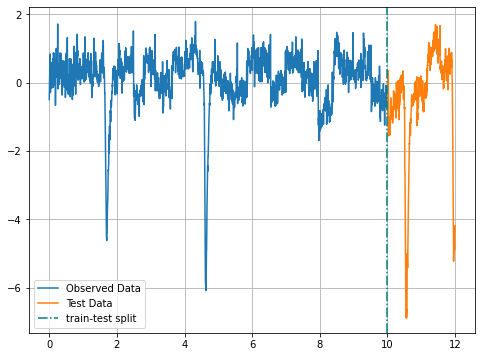

In [3]:
def plot_data(train_x, train_y, test_x, test_y):
    (f, ax) = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(train_x.numpy(), train_y.numpy(), label='Observed Data')
    ax.plot(test_x.numpy(), test_y.numpy(), label='Test Data')
    ax.axvline(train_length, label='train-test split', color='teal', linestyle='-.')
    ax.grid('both')
    ax.legend()
    return ax

plot_data(train_x, train_y, test_x, test_y)

# Define the GP model

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


## Initialize likelihood & model
For more info on hyperparameters, constraints and priors: [click here](https://github.com/cornellius-gp/gpytorch/blob/master/examples/00_Basic_Usage/Hyperparameters.ipynb)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-2),
    noise_prior=gpytorch.priors.NormalPrior(0, 1))
model = ExactGPModel(train_x, train_y, likelihood)
print("The Model:\n", model)
print("The Likelihood:\n", likelihood)

The Model:
 ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-02)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)
The Likelihood:
 GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (noise_prior): NormalPrior()
    (raw_noise_constraint): GreaterThan(1.000E-02)
  )
)


## View model hyperparameters
Explicitly: objects of type torch.nn.Parameter that will have gradients filled in by autograd.

In [6]:
def print_model_params(model):
    for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item()}')

print_model_params(model)

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


## View model state dict
Both parameters and persistent buffers (e.g. running averages) are included.

In [7]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.noise_prior.loc', tensor(0.)),
             ('likelihood.noise_covar.noise_prior.scale', tensor(1.)),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(0.0100)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.constant', tensor([0.])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(

## View model constraints

In [8]:
list(model.named_constraints())


[('likelihood.noise_covar.raw_noise_constraint', GreaterThan(1.000E-02)),
 ('covar_module.raw_outputscale_constraint', Positive()),
 ('covar_module.base_kernel.raw_lengthscale_constraint', Positive())]

## Train the model
In training mode, `model(train_x)` gives the latent prior distribution $P(f(x^*))$ on a given input.

In [9]:
# change from .eval() to .train() mode
# .train() mode is for optimizing model hyperparameters
# .eval() is for computing predictions through the model posterior
model.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[40])

num_iters = 50

for i in range(num_iters):
    optimizer.zero_grad()  # resets gradients to zero
    output = model(train_x)  #  a multivariate gaussian of the prior
    loss = -mll(output, train_y) #  The marginal (f) log likelihood of the observation y conditioned on X
    loss.backward()  # computes the gradient of loss w.r.t. graph leaves
    optimizer.step()  # updates the models parameters

    if i % 10 == 0:
        print(f'Iteration {i} - loss = {loss:.2f} - noise = {model.likelihood.noise.item():e}')
    scheduler.step()

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ..\aten\src\ATen\native\Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iteration 0 - loss = 1.11 - noise = 6.981597e-01
Iteration 10 - loss = 1.09 - noise = 6.496703e-01
Iteration 20 - loss = 1.07 - noise = 6.042678e-01
Iteration 30 - loss = 1.04 - noise = 5.614775e-01
Iteration 40 - loss = 1.01 - noise = 5.248646e-01


## Make predictions
Switch the model and likelihood into evaluation (predictive posterior) mode.

`model(test_x)` returns posterior $p(f(x^*) \mid X, y)$ as type `gpytorch.MultivariateNormal`

`likelihood(test_x)` returns conditional $p(y \mid f(x))$ as type`torch.Distribution`
`likelihood(model(test_x))` returns marginal $p(y \mid x)$ as type`gpytorch.MultivariateNormal`

In [10]:
model.eval()
likelihood.eval()
torch.set_grad_enabled(False)

test_x_f = torch.cat([train_x, test_x], dim=-1)  # concat train and test
test_y_f = torch.cat([train_y, test_y], dim=-1)  # concat train and test
observed_pred = model.likelihood(model(test_x_f))  #  marginal distribution over train and test

In [22]:
posterior = model(test_x_f)
marginal = likelihood(model(test_x_f))
conditional = likelihood(test_x_f)
lower_a, upper_a = posterior.confidence_region()
mean = posterior.mean

lower = observed_pred.mean - 1.96 * observed_pred.stddev
upper = observed_pred.mean + 1.96 * observed_pred.stddev

## Plot results


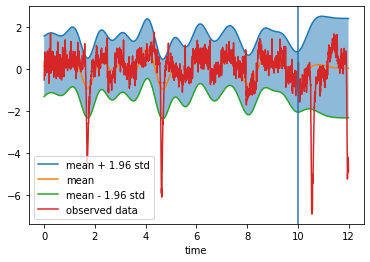

In [12]:
plt.plot(test_x_f, upper, label="mean + 1.96 std")
plt.plot(test_x_f, mean, label="mean")
plt.plot(test_x_f, lower, label="mean - 1.96 std")
plt.plot(test_x_f, test_y_f, label="observed data")
plt.axvline(train_length)
plt.fill_between(test_x_f, lower, upper, alpha=0.5)
plt.xlabel("time")
plt.legend()

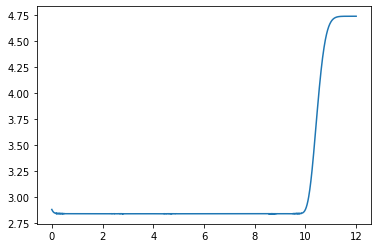

In [13]:
plt.plot(test_x_f, upper - lower)


## Evaluate Model Predictive Accuracy
We evaluate the predictive accuracy via the $lpd$.

In [23]:
predictive_posterior = model.likelihood(model(test_x))
predictive_accuracy = predictive_posterior.log_prob(test_y)

## Misc
* To save and load model state: [click here](https://github.com/cornellius-gp/gpytorch/blob/master/examples/00_Basic_Usage/Saving_and_Loading_Models.ipynb)